# Image vector search using Azure Cosmos DB for PostgreSQL

In this notebook, we will build a basic image vector similarity search application using the Azure AI Vision Image Retrieval APIs and Azure Cosmos DB for PostgreSQL.

In Azure Cosmos DB for PostgreSQL, vector similarity search is enabled by the `pgvector` extension.

Before you start:

1. Create an Azure Cosmos DB for PostgreSQL cluster, enable the `pgvector` extension, and create a table to store vector data.
2. Create an Azure Blob Storage container to store the images.
3. Run the `upload_images.py` script to upload the images in your Blob Storage container. (Image source: [Visual Geometry Group - University of Oxford](https://www.robots.ox.ac.uk/~vgg/data/paintings/))
4. Run the `generate_embeddings.py` script to compute the embeddings of all the images. The embeddings are saved in a `.csv` file in the *embeddings* folder.
5. Run the `upload_embeddings.py` script to populate the PostgreSQL table with data.

## Import libraries

In [1]:
import os
import io
import math
import psycopg2
from psycopg2 import pool
from dotenv import load_dotenv
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient
from azurecv import text_embedding, image_embedding

# Load environment variables

In [2]:
load_dotenv()

# Azure Cosmos DB for PostgreSQL
postgres_host = os.getenv("POSTGRES_HOST")
postgres_database_name = os.getenv("POSTGRES_DB_NAME")
postgres_user = os.getenv("POSTGRES_USER")
postgres_password = os.getenv("POSTGRES_PASSWORD")
sslmode = "require"
table_name = os.getenv("POSTGRES_TABLE_NAME")

In [3]:
# Azure AI Vision
cv_endpoint = os.getenv('CV_ENDPOINT') + "computervision/"
cv_key = os.getenv('CV_KEY')

In [4]:
# Azure Blob Storage
blob_account_name = os.getenv("BLOB_ACCOUNT_NAME")
blob_account_key = os.getenv("BLOB_ACCOUNT_KEY")
blob_endpoint_suffix = os.getenv("BLOB_ENDPOINT_SUFFIX")
blob_connection_string = (
    f"DefaultEndpointsProtocol=https;AccountName={blob_account_name};"
    f"AccountKey={blob_account_key};EndpointSuffix={blob_endpoint_suffix}"
)
container_name = os.getenv("CONTAINER_CLIENT")
blob_service_client = BlobServiceClient.from_connection_string(blob_connection_string)
container_client = blob_service_client.get_container_client(container=container_name)

## Connect to Azure Cosmos DB for PostgreSQL

Connect to the Azure Cosmos DB for PostgreSQL cluster.

The following code forms a connection string using the environment variables for your Azure Cosmos DB for PostgreSQL cluster and creates a connection pool to your Postgres database. After that, a `cursor` object is created, which can be used to execute SQL queries with the `execute()` method.

In [5]:
# Build a connection string from the variables
postgres_connection_string = (
    f"host={postgres_host} user={postgres_user} dbname={postgres_database_name} "
    f"password={postgres_password} sslmode={sslmode}"
)

In [6]:
postgresql_pool = psycopg2.pool.SimpleConnectionPool(1, 20, postgres_connection_string)
if (postgresql_pool):
    print("Connection pool created successfully")

Connection pool created successfully


In [7]:
# Get a connection from the connection pool
conn = postgresql_pool.getconn()
cursor = conn.cursor()

### Select the first 10 rows of the table to see the data

In [8]:
# Fetch all rows from table
cursor.execute(f"SELECT * FROM {table_name} LIMIT 10;")
rows = cursor.fetchall()

# Print all rows
df_rows = pd.DataFrame(rows, columns=["filename", "embeddings"])
df_rows.head(10)

,filename,embeddings
0,ABD_AAG_000196-001.jpg,"[0.81933594,3.3125,3.2929688,-1.6181641,-2.697..."
1,ABD_AAG_000720-001.jpg,"[-4.0429688,-1.7792969,-0.014961243,-1.5419922..."
2,ABD_AAG_002200-001.jpg,"[-0.7836914,0.10253906,3.3476562,3.0214844,-0...."
3,ABD_AAG_002215-001.jpg,"[0.23522949,0.057281494,2.4453125,1.4189453,-3..."
4,ABD_AAG_002276-001.jpg,"[-1.2304688,-1.1445312,4.6679688,-0.7260742,-2..."
5,ABD_AAG_002750-001.jpg,"[-0.2442627,1.125,0.94970703,-5.2695312,-0.026..."
6,ABD_AAG_002751-001.jpg,"[-1.1025391,0.13024902,-0.6015625,-4.421875,-2..."
7,ABD_AAG_003271-001.jpg,"[-2.6835938,-1.3544922,3.5449219,-0.47314453,-..."
8,ABD_AAG_003566-001.jpg,"[-0.21325684,-1.3808594,1.1923828,1.1640625,4...."
9,ABD_AAG_003645-001.jpg,"[2.9179688,-1.2197266,1.4707031,0.13208008,-2...."


## Search images using an image or a text prompt

After populating the table with vector data, you can use this image collection to search for images that are most similar to a reference image or a text prompt. The workflow is summarized as follows:

1. Use the Vectorize Image API or the Vectorize Text API to generate vector embeddings of an image or text, respectively.
2. To calculate similarity and retrieve images, use `SELECT` statements and the built-it vector operators of the PostgreSQL database.
3. Display the retrieved images using the `display_image_grid()` function.


**Helper Function**

In [9]:
def display_image_grid(image_names, captions, title, nrows, ncols):
    num_images = len(image_names)
    
    # Download the images from Azure Blob Storage
    image_stream = []
    for image_file in image_names:
        blob_client = container_client.get_blob_client(image_file)
        blob_image = blob_client.download_blob().readall()
        image_stream.append(io.BytesIO(blob_image))

    # Display the images
    f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(Image.open(image_stream[i]))
            ax.set_title(captions[i], fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')
    f.suptitle(title, fontsize=14)
    f.subplots_adjust(top=0.9)
    f.tight_layout()
    plt.show()

### Text-to-Image Search

#### Calculate the vector embeddings of the text prompt

In [10]:
# Generate the embedding of the text prompt
txt = "a table with flowers"
txt_emb = text_embedding(txt, cv_endpoint, cv_key)

#### Query the table to find the most similar images

In [11]:
# Vector search
topn = 12
cursor.execute(f"SELECT * FROM {table_name} ORDER BY embedding <=> %s LIMIT {topn}", (str(txt_emb),))

# Display the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(rows, columns=["filename", "embeddings"])
df_rows.head(topn)

,filename,embeddings
0,EDI_CITY_CAC_155_1998-001.jpg,"[1.1396484,1.2285156,0.8496094,-4.9492188,-3.6..."
1,ABD_AAG_ag004384-001.jpg,"[-0.72021484,0.67041016,0.18884277,-3.5742188,..."
2,NTV_UNN_46-001.jpg,"[1.4658203,1.3144531,2.8359375,-4.4101562,-3.5..."
3,NSC_IMAG_HCEU_EU_SAC_118-001.jpg,"[0.4963379,3.2363281,0.375,-0.8330078,-4.65234..."
4,ABD_AAG_ag013616-001.jpg,"[1.3046875,0.8154297,-1.9931641,-2.8554688,-2...."
5,ABD_RGU_147-001.jpg,"[3.875,1.0566406,0.9169922,0.52490234,-1.92578..."
6,ABD_AAG_ag002177-001.jpg,"[1.2070312,0.030654907,-0.58740234,-2.0644531,..."
7,NY_YAG_YORAG_19-001.jpg,"[0.9951172,0.03112793,-2.2792969,-3.6679688,-3..."
8,ABD_RGU_744-001.jpg,"[1.7246094,-0.04916382,0.7998047,-4.3398438,0...."
9,ACC_ACC_AC_2065-001.jpg,"[2.3984375,-0.15527344,-0.8154297,-0.5058594,-..."


#### Display the retrieved images

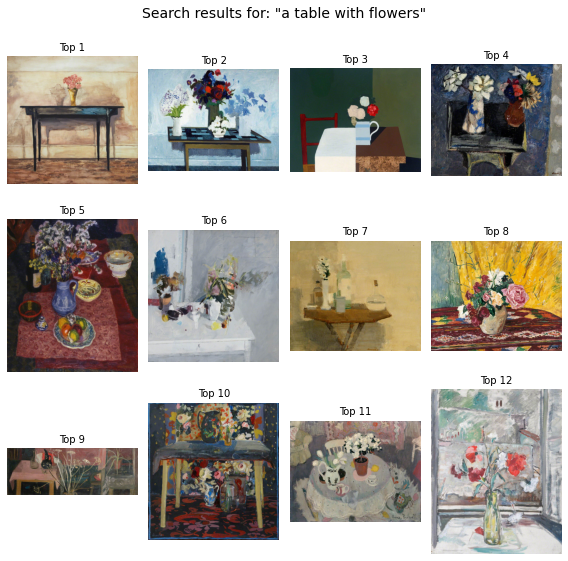

In [12]:
image_names = [row[0] for row in rows]
captions = [f"Top {i+1}" for i in range(len(image_names))]
ncols = 4
nrows = math.ceil(len(image_names)/ncols)
display_image_grid(image_names, captions, 'Search results for: "' + txt + '"', nrows, ncols)

#### Query the table to find the cosine similarity

In [13]:
cursor.execute(
    f"""
        SELECT filename, 1 - (embedding <=> %s) AS cosine_similarity 
        FROM {table_name} 
        ORDER BY embedding <=> %s 
        LIMIT {topn}
    """,
    (str(txt_emb), str(txt_emb))
)

# Display the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(rows, columns=["filename", "cosine_similarity"])
df_rows.head(topn)

,filename,cosine_similarity
0,EDI_CITY_CAC_155_1998-001.jpg,0.381347
1,ABD_AAG_ag004384-001.jpg,0.377152
2,NTV_UNN_46-001.jpg,0.368057
3,NSC_IMAG_HCEU_EU_SAC_118-001.jpg,0.364943
4,ABD_AAG_ag013616-001.jpg,0.358925
5,ABD_RGU_147-001.jpg,0.358611
6,ABD_AAG_ag002177-001.jpg,0.358484
7,NY_YAG_YORAG_19-001.jpg,0.355170
8,ABD_RGU_744-001.jpg,0.354413
9,ACC_ACC_AC_2065-001.jpg,0.353740


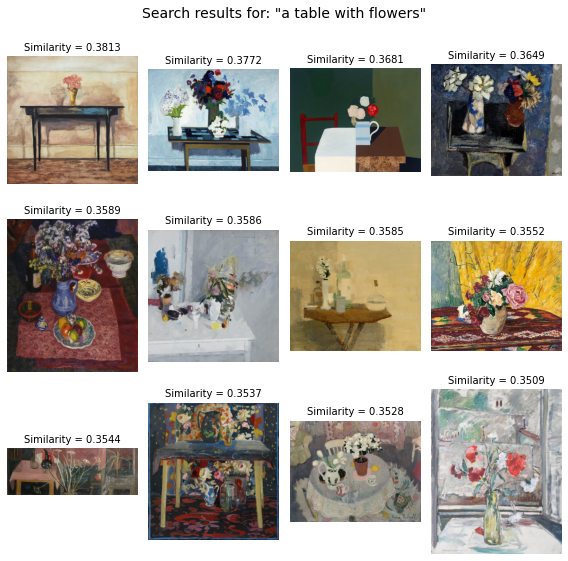

In [14]:
image_names = [row[0] for row in rows]
similarity_values = [row[1] for row in rows]
captions = [f"Similarity = {round(similarity_values[i], 4)}" for i in range(len(image_names))]
ncols = 4
nrows = math.ceil(len(image_names)/ncols)
display_image_grid(image_names, captions, 'Search results for: "' + txt + '"', nrows, ncols)

#### Get images with a cosine similarity value above a threshold

In [15]:
threshold = 0.356
cursor.execute(
    f"""
        SELECT filename, 1 - (embedding <=> %s) AS cosine_similarity 
        FROM {table_name} 
        WHERE 1 - (embedding <=> %s) > {threshold} 
        ORDER BY embedding <=> %s 
        LIMIT {topn}
    """,
    (str(txt_emb), str(txt_emb), str(txt_emb))
)

# Display the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(rows, columns=["filename", "cosine_similarity"])
df_rows.head(topn)

,filename,cosine_similarity
0,EDI_CITY_CAC_155_1998-001.jpg,0.381347
1,ABD_AAG_ag004384-001.jpg,0.377152
2,NTV_UNN_46-001.jpg,0.368057
3,NSC_IMAG_HCEU_EU_SAC_118-001.jpg,0.364943
4,ABD_AAG_ag013616-001.jpg,0.358925
5,ABD_RGU_147-001.jpg,0.358611
6,ABD_AAG_ag002177-001.jpg,0.358484


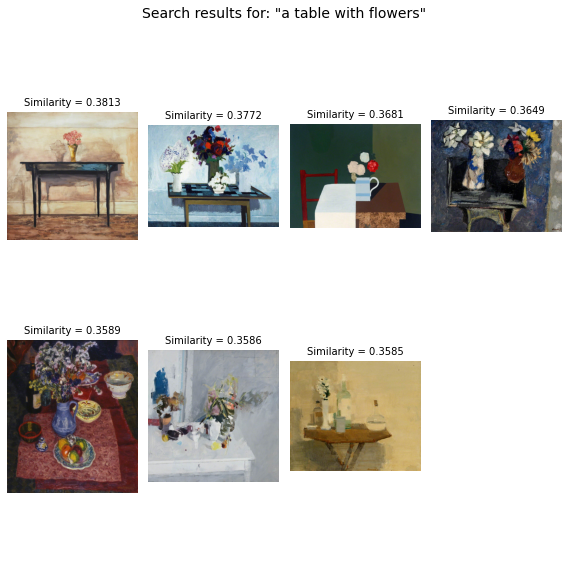

In [16]:
image_names = [row[0] for row in rows]
similarity_values = [row[1] for row in rows]
captions = [f"Similarity = {round(similarity_values[i], 4)}" for i in range(len(image_names))]
ncols = 4
nrows = math.ceil(len(image_names)/ncols)
display_image_grid(image_names, captions, 'Search results for: "' + txt + '"', nrows, ncols)

### Image-to-Image Search

#### Calculate the vector embeddings of the reference image

In [17]:
# Generate the embedding of the reference image
ref_image = "reference_image.jpg"
image_emb = image_embedding(ref_image, cv_endpoint, cv_key)

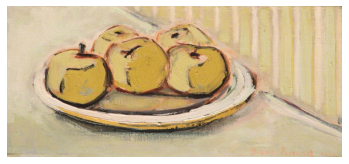

In [18]:
# Display the reference image
plt.imshow(Image.open(ref_image))
plt.axis('off')
plt.show()

#### Query the table to find the most similar images

In [19]:
cursor.execute(
    f"""
        SELECT filename, 1 - (embedding <=> %s) AS cosine_similarity 
        FROM {table_name} 
        ORDER BY embedding <=> %s 
        LIMIT {topn}
    """,
    (str(image_emb), str(image_emb))
)

# Display the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(rows, columns=["filename", "cosine_similarity"])
df_rows.head(topn)

,filename,cosine_similarity
0,CW_RCP_A12-001.jpg,0.832565
1,STF_SAMS_G92_001_0001-001.jpg,0.757316
2,CIA_CIA_P_1982_LB_412-001.jpg,0.751831
3,NOT_NCMG_1927_75-001.jpg,0.751059
4,NOT_NCMG_1944_29-001.jpg,0.745675
5,ACC_ACC_AC_3-001.jpg,0.743387
6,CW_FAG_FAMAG_2002_9_23-001.jpg,0.728277
7,EDII_RSA_G_1991_066-001.jpg,0.726303
8,NY_YAG_YORAG_1141-001.jpg,0.725889
9,ABD_RGU_DSCF0456-001.jpg,0.719435


#### Display the results

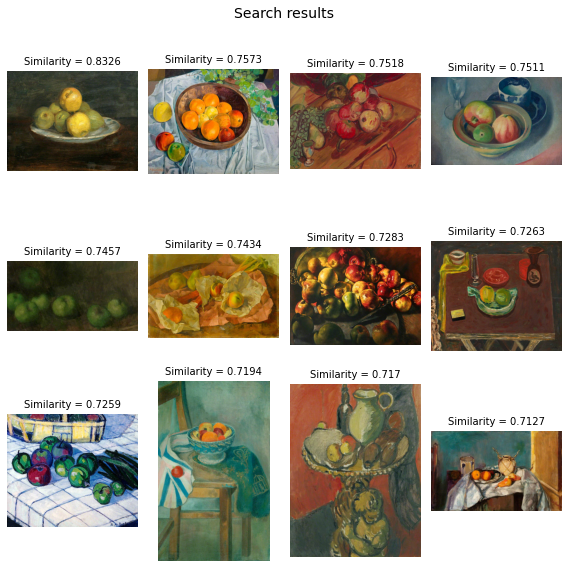

In [21]:
image_names = [row[0] for row in rows]
similarity_values = [row[1] for row in rows]
captions = [f"Similarity = {round(similarity_values[i], 4)}" for i in range(len(image_names))]
ncols = 4
nrows = math.ceil(len(image_names)/ncols)
display_image_grid(image_names, captions, "Search results", nrows, ncols)

#### Find the most similar images to an image of the dataset

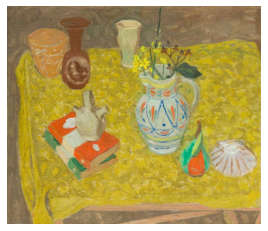

In [22]:
image_file = "ABD_AAG_008122-001.jpg"

# Download the image from Azure Blob Storage
blob_client = container_client.get_blob_client(image_file)
blob_image = blob_client.download_blob().readall()
image_stream = io.BytesIO(blob_image)

# Display the reference image
plt.imshow(Image.open(image_stream))
plt.axis('off')
plt.show()

In [23]:
cursor.execute(
    f"""
        SELECT * FROM {table_name} 
        WHERE filename != %s
        ORDER BY embedding <=> (SELECT embedding FROM {table_name} WHERE filename = %s) 
        LIMIT {topn}
    """,
    (image_file, image_file)
)

# Display the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(rows, columns=["filename", "embeddings"])
df_rows.head(topn)

,filename,embeddings
0,EDII_RSA_G_1991_066-001.jpg,"[1.6816406,-0.45361328,0.75927734,0.27490234,-..."
1,ABD_RGU_68-001.jpg,"[0.18261719,0.38867188,-1.4101562,-0.2705078,-..."
2,ABD_AAG_ag002243-001.jpg,"[-1.3427734,2.0371094,-0.3425293,-1.0927734,-4..."
3,ABD_AAG_ag013616-001.jpg,"[1.3046875,0.8154297,-1.9931641,-2.8554688,-2...."
4,ABD_RGU_DSCF2791-001.jpg,"[-0.1998291,-0.31079102,-0.2052002,-0.94628906..."
5,STF_STKMG_1947_FA_761-001.jpg,"[-2.6210938,0.8984375,0.6098633,-2.8769531,-5...."
6,ABD_RGU_DSCF4185-001.jpg,"[1.1601562,-0.85595703,1.0234375,-1.7714844,-5..."
7,ABD_RGU_16-001.jpg,"[1.2216797,1.0986328,-0.5961914,-1.4775391,-4...."
8,ABD_RGU_DSCF2659-001.jpg,"[0.09655762,0.22241211,0.12878418,-1.78125,-4...."
9,ABD_RGU_DSCF1947-001.jpg,"[0.48217773,1.53125,1.8876953,-1.2509766,-3.45..."


#### Display the results

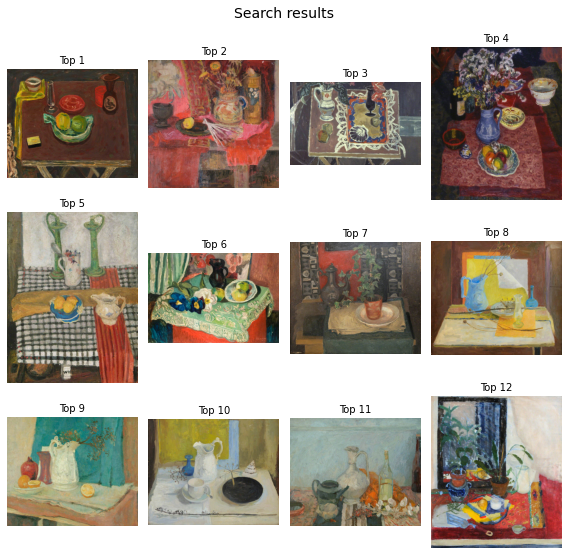

In [24]:
image_names = [row[0] for row in rows]
captions = [f"Top {i+1}" for i in range(len(image_names))]
ncols = 4
nrows = math.ceil(len(image_names)/ncols)
display_image_grid(image_names, captions, "Search results", nrows, ncols)

## Close the connection

In [25]:
conn.commit()
cursor.close()
conn.close()